# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as st
from numpy.random import RandomState
import math

random_state = 54321

## Загрузка и подготовка данных

### Анализ данных

In [2]:
data = [
    {
        "raw": pd.read_csv('/datasets/geo_data_0.csv'),
        "name": "Первый регион"
    },
    {
        "raw": pd.read_csv('/datasets/geo_data_1.csv'),
        "name": "Второй регион"
    },
    {
        "raw": pd.read_csv('/datasets/geo_data_2.csv'),
        "name": "Третий регион"
    }
]

In [3]:
for item in data:
    df = item["raw"]
    print(item['name'] + ":")
    df.info()    
    print()
    print(df.head())
    print()
    print()

Первый регион:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647


Второй регион:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 

* Колонка id идентифицирует скважину - для построения модели она не нужна и требует удаления из данных
* В данных нет пропусков
* Данные не требуют приведения типов
* Все признаки числовые и не требуют кодирования
* Заголовки колонок не требуют нормализации

### Предобработка данных

#### Удаление лишней колонки

In [4]:
for item in data:
    item["raw"] = item["raw"].drop("id", axis=1)

#### Обработка выбросов

In [5]:
numeric_columns = [
    'f0', 
    'f1', 
    'f2'  
]

In [6]:
hist_per_row = 3
height_per_row = 3

def check_emissions(df, numeric_columns):
    columns_count = len(numeric_columns)
    rows = int(columns_count / 3) + (1 if (columns_count % 3 > 0) else 0)
    display(df[numeric_columns].describe())
    
    axis = df[numeric_columns].hist(bins=50, figsize=(20,height_per_row * rows), layout=(rows, hist_per_row));    
    pl.suptitle("Гистограммы признаков", y=1.05)
    for ax in axis.flatten():
        ax.set_xlabel("Значение признака")
        ax.set_ylabel("Количество скважин")       

##### Первый регион

,f0,f1,f2
count,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647
std,0.871832,0.504433,3.248248
min,-1.408605,-0.848218,-12.088328
25%,-0.072580,-0.200881,0.287748
50%,0.502360,0.250252,2.515969
75%,1.073581,0.700646,4.715088
max,2.362331,1.343769,16.003790


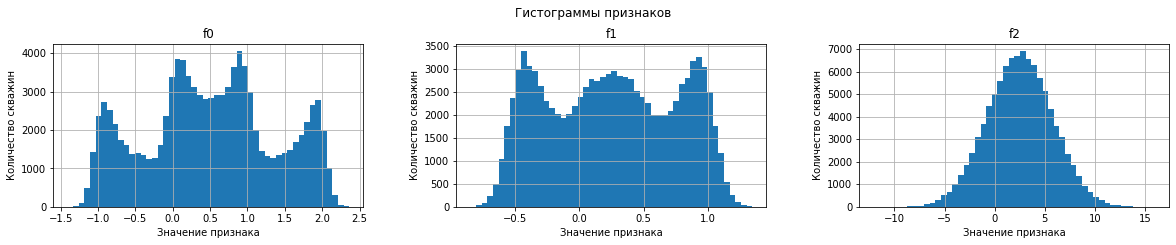

In [7]:
check_emissions(data[0]['raw'], numeric_columns)

Нет явных выбросов, которые требовалось бы устранять.

##### Второй регион

,f0,f1,f2
count,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541
std,8.965932,5.119872,1.703572
min,-31.609576,-26.358598,-0.018144
25%,-6.298551,-8.267985,1.000021
50%,1.153055,-4.813172,2.011479
75%,8.621015,-1.332816,3.999904
max,29.421755,18.734063,5.019721


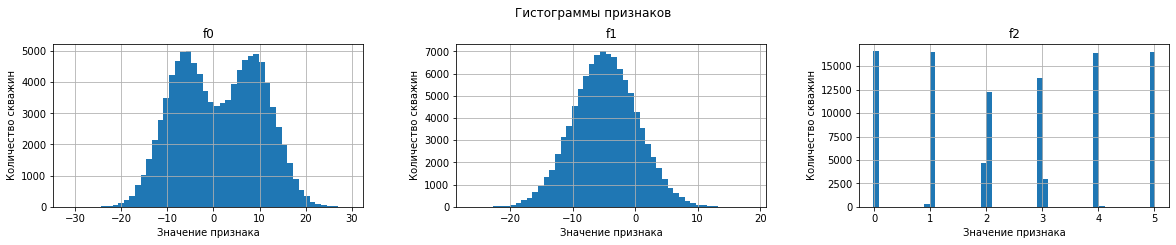

In [8]:
check_emissions(data[1]['raw'], numeric_columns)

Выбросов нет, хотя f2 вызывает некоторое беспокойство.

##### Третий регион

,f0,f1,f2
count,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128
std,1.732045,1.730417,3.473445
min,-8.760004,-7.084020,-11.970335
25%,-1.162288,-1.174820,0.130359
50%,0.009424,-0.009482,2.484236
75%,1.158535,1.163678,4.858794
max,7.238262,7.844801,16.739402


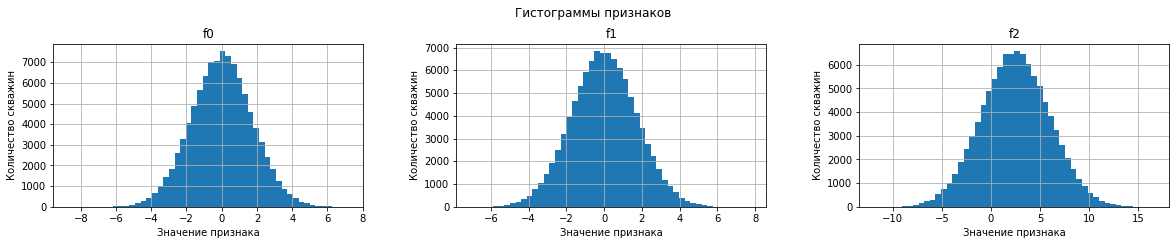

In [9]:
check_emissions(data[2]['raw'], numeric_columns)

Нет явных выбросов требующих устранения.

#### Разбивка данных

In [10]:
for item in data:
    df = item['raw']
    features = df.drop('product', axis=1)
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=random_state
    )
    
    item['train'] = {
        'features': features_train,
        'target': target_train
    }
    item['valid'] = {
        'features': features_valid,
        'target': target_valid
    }

##### Проверка разбивки

In [11]:
for item in data:
    print(item['name'] + ':')
    print('features train:', item['train']['features'].shape)
    print('target train:', item['train']['features'].shape)
    print('features valid:', item['valid']['features'].shape)
    print('target valid:', item['valid']['target'].shape)
    print()

Первый регион:
features train: (75000, 3)
target train: (75000, 3)
features valid: (25000, 3)
target valid: (25000,)

Второй регион:
features train: (75000, 3)
target train: (75000, 3)
features valid: (25000, 3)
target valid: (25000,)

Третий регион:
features train: (75000, 3)
target train: (75000, 3)
features valid: (25000, 3)
target valid: (25000,)



Все правильно: тренировочная выборка - 75%, валидационная - 25%

##### Масштабирование

In [12]:
pd.options.mode.chained_assignment = None
for item in data:
    scaler = StandardScaler()
    item['train']['features'] = scaler.fit_transform(item['train']['features'])
    item['valid']['features'] = scaler.transform(item['valid']['features'])

## Обучение и проверка модели

In [13]:
for item in data:
    model = LinearRegression()
    model.fit(item['train']['features'], item['train']['target'])
    predicted = model.predict(item['valid']['features'])
    
    item['valid']['result'] = pd.DataFrame({
        'target': item['valid']['target'],
        'predicted': predicted 
    })
    
    print(item['name'] + ':')
    print('Средний запас предсказанного сырья:', predicted.mean())
    print('Средний запас реальный:', item['valid']['target'].mean())
    print('rmse:', mean_squared_error(item['valid']['target'], predicted, squared=False))
    print()
    

Первый регион:
Средний запас предсказанного сырья: 92.15921155743655
Средний запас реальный: 92.58379661728391
rmse: 37.68341093860808

Второй регион:
Средний запас предсказанного сырья: 68.44594093153303
Средний запас реальный: 68.44435360774597
rmse: 0.8922819708481475

Третий регион:
Средний запас предсказанного сырья: 94.92229500787454
Средний запас реальный: 95.07834473652275
rmse: 40.15250541784856



Средний запас по региону вычисляется точно.

Однако rmse оказался высоким для первого и третьего регионов - с их моделями могут быть проблемы.

## Подготовка к расчёту прибыли

In [14]:
total_points_per_region = 500
required_best_points = 200
budget_per_region = 10000000000
income_per_barrel = 450
barrel_per_product = 1000
income_per_product = income_per_barrel * barrel_per_product
bootstrap_samples_count = 1000
max_loss_probability = 0.025

In [15]:
budget_per_point = budget_per_region / required_best_points
lossless_product_amount = int(budget_per_point / income_per_product)

print("Средний бюджет на скважину: {:,.0f}".format(budget_per_point))
print("Средний требующийся объем продукта со скважины для покрытия бюджета:", lossless_product_amount)

Средний бюджет на скважину: 50,000,000
Средний требующийся объем продукта со скважины для покрытия бюджета: 111


Средний реальный объем со скважин ниже требующегося объема. Если геологи выберут неудачные скважины, то хороший регион может быть пропущен.

На всякий случай можно проверить, что в данных по представленным регионам есть подходящие скважины.

In [16]:
for item in data:
    print(item['raw'].query('product > ' + str(lossless_product_amount))['product'].count())

36676
16537
38278


Шанс найти подходящие скважины - не больше 38%. Но, в любом случае, для безубыточности требуется не 200 скважин по 111 "продукта", а 200x111 "продукта" на 200 скважин 

### Функция расчета прибыли

In [17]:
def calculate_profit(target_with_prediction):
    best_predicted_points = target_with_prediction.sort_values('predicted', ascending=False).iloc[:required_best_points]
    total_product = best_predicted_points['target'].sum()
    total_income = total_product * income_per_product
    return total_income - budget_per_region

In [18]:
for item in data:
    profit = calculate_profit(item['valid']['result'])
    print(item['name'] + ',', 'доход лучших предсказанных скважин: {:,.0f}'.format(profit))

Первый регион, доход лучших предсказанных скважин: 3,178,631,596
Второй регион, доход лучших предсказанных скважин: 2,415,086,697
Третий регион, доход лучших предсказанных скважин: 2,413,785,636


Если бы геологи могли исследовать в регионе сразу по 25000 скважин, то прибыль с лучших 200 была бы колоссальной.

## Расчёт прибыли и рисков 

In [19]:
def test_income(points_per_region):
    profit_per_region = pd.DataFrame()    
    
    for item in data:
        profit = []
        samples_source = item['valid']['result']
        random = RandomState(random_state)

        for i in range(0, bootstrap_samples_count):
            sample = samples_source.sample(points_per_region, replace=True, random_state=random)
            sample_profit = calculate_profit(sample) / 1000000
            profit.append(sample_profit)

        asSeries = pd.Series(profit, name=item['name'])
        losses_probability = asSeries[asSeries < 0].count() / bootstrap_samples_count
        trusted_interval = st.norm.interval(0.95, loc=asSeries.mean(), scale=asSeries.sem())
        profit_per_region = profit_per_region.join(asSeries, how='right')

        print(item['name'])
        print('Средняя прибыль: {:,.0f} млн.'.format(asSeries.mean()))
        print('Вероятность убытков: {:.2f}%'.format(losses_probability * 100, 2))
        print('Доверительный интервал:', '{:,.0f} млн.'.format(trusted_interval[0]), '-', '{:,.0f} млн.'.format(trusted_interval[1]))
        print()
    
    axis = profit_per_region.hist(bins=20, figsize=(20, height_per_row), layout=(1, hist_per_row), sharey=True, sharex=True)  
    pl.suptitle("Гистограммы прибыли по регионам", y=1.05)        
    for ax in axis.flatten():
        ax.set_xlabel("Прибыль, млн.")
        ax.set_ylabel("Количество скважин")

Первый регион
Средняя прибыль: 378 млн.
Вероятность убытков: 6.80%
Доверительный интервал: 363 млн. - 394 млн.

Второй регион
Средняя прибыль: 411 млн.
Вероятность убытков: 2.10%
Доверительный интервал: 399 млн. - 424 млн.

Третий регион
Средняя прибыль: 397 млн.
Вероятность убытков: 7.60%
Доверительный интервал: 380 млн. - 413 млн.



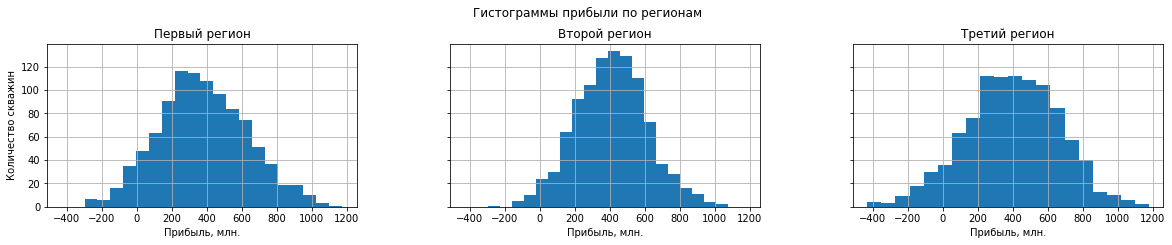

In [20]:
test_income(total_points_per_region)

Сокращение выборок с 25000 до 500 привело к тому, что прогнозируемая прибыль упала в 10 раз.

Наибольшую прибыль принесет второй район. Также, у него и наименьшая вероятность убытков. Поэтому, второй регион можно посоветовать разрабатывать. Остальные регионы не преодолевают целевую вероятность убытков в 2,5%

### Увеличение выборки скважин

Вычисления показали, что потенциальная прибыль зависит от размера исследованных на старте скважин. Так, исследование 25000 скважин (что в реальности невозможно) позволяет удесетерить доход относительно исследования 500 скважин. Но, возможно, увеличить прибыль реально меньшими силами. Стоит попробовать увеличить стартовую выборку не в 10+ раз, а, например, на 50%:

Первый регион
Средняя прибыль: 914 млн.
Вероятность убытков: 0.00%
Доверительный интервал: 899 млн. - 929 млн.

Второй регион
Средняя прибыль: 1,347 млн.
Вероятность убытков: 0.00%
Доверительный интервал: 1,339 млн. - 1,355 млн.

Третий регион
Средняя прибыль: 871 млн.
Вероятность убытков: 0.10%
Доверительный интервал: 855 млн. - 887 млн.



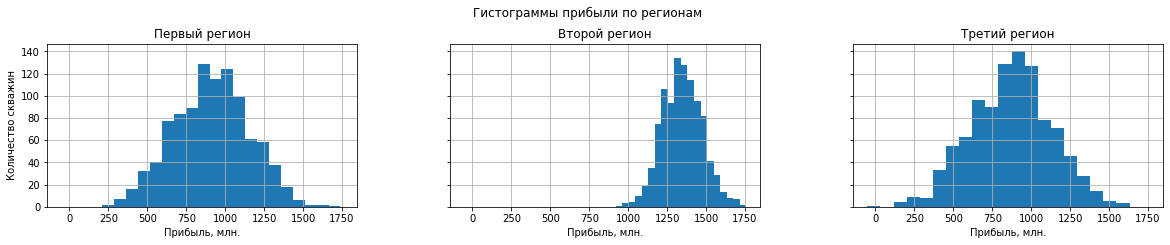

In [21]:
test_income(750)

Увеличение выборки всего в полтора раза позволяет найти больше хороших скважин и увеличить прибыль с лучших 200 в 2-3 раза.

## Итоги

* Предоставленные исходные данные были высокого качества и практически не потребовали предобработки.
* Второй регион преодолел планку в 2.5% вероятности убытков и может быть посоветован для разработки.
* Увеличение стартовой выборки скважин с 500 до 750 может позволить увеличить стартовую прибыль в 2-3 раза.